# Audio Classfication Moedel


In [ ]:
pip install librosa tensorflow torchaudio

In [2]:
import torchaudio
dataset = torchaudio.datasets.SPEECHCOMMANDS(".", download=True)
#Google Speech Commands Dataset

100%|██████████████████████████████████████| 2.26G/2.26G [00:59<00:00, 41.0MB/s]


## Librosa:Audio pre-processing

In [57]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

# row_datatoMel-Spectrogram
def extract_features(audio_path):
    y, sr = librosa.load(audio_path, sr=16000)  #y:audio signal sampling rate->16kHz
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)  # Mel-spectrogram
    log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)  # todB mel_spec range too huge
    max_time_steps=32
    if log_mel_spec.shape[1] > max_time_steps:
        log_mel_spec = log_mel_spec[:, :max_time_steps]  # truncation
    elif log_mel_spec.shape[1] < max_time_steps:
        pad_width = max_time_steps - log_mel_spec.shape[1]
        log_mel_spec = np.pad(log_mel_spec, ((0, 0), (0, pad_width)), mode='constant')  # padding 0 to step32

    return log_mel_spec



In [58]:
log_mel_spec = extract_features(sample_audio)

print("Mel-Spectrogram (n_mels,hopsize):", log_mel_spec.shape)

Mel-Spectrogram (n_mels,hopsize): (128, 32)


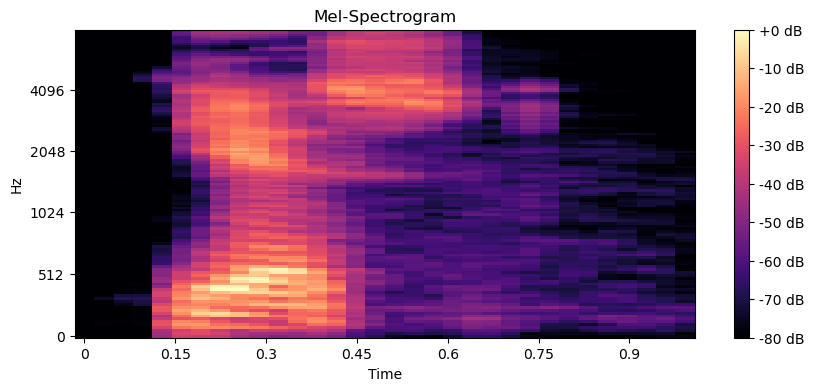

In [59]:

# test
sample_audio = "./SpeechCommands/speech_commands_v0.02/yes/0a2b400e_nohash_2.wav"  
features = extract_features(sample_audio)

# Mel-spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(features, sr=16000, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title("Mel-Spectrogram")
plt.show()

In [35]:
#test different number of mel_spec & hop_size


def visualize_mel_spectrogram(sample_audio, n_mels_list=[64, 128, 256], hop_length_list=[8, 16, 32]):
    """
     print Mel-Spectrogram under different n_mels & hop_length 
    
    input:
    - sample_audio: audio_path (str)
    - n_mels_list)
    - hop_length_list
    """
    # loading
    y, sr = librosa.load(sample_audio, sr=16000)

    
    fig, axs = plt.subplots(len(n_mels_list), len(hop_length_list), figsize=(12, 8))

    for i, n_mels in enumerate(n_mels_list):
        for j, hop_length in enumerate(hop_length_list):
            # compute Mel-Spectrogram
            mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, hop_length=hop_length)
            log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)  # normalization max

            # visual Mel-Spectrogram
            ax = axs[i, j]
            img = librosa.display.specshow(
                log_mel_spec, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel',
                ax=ax, fmax=4000, cmap='magma', vmin=-50, vmax=0 
            )
            ax.set_title(f"n_mels={n_mels}, hop_length={hop_length}")

    #  colorbar
    for j in range(len(hop_length_list)):  
        fig.colorbar(img, ax=axs[-1, j], format="%+2.0f dB")

    plt.tight_layout()
    plt.show()

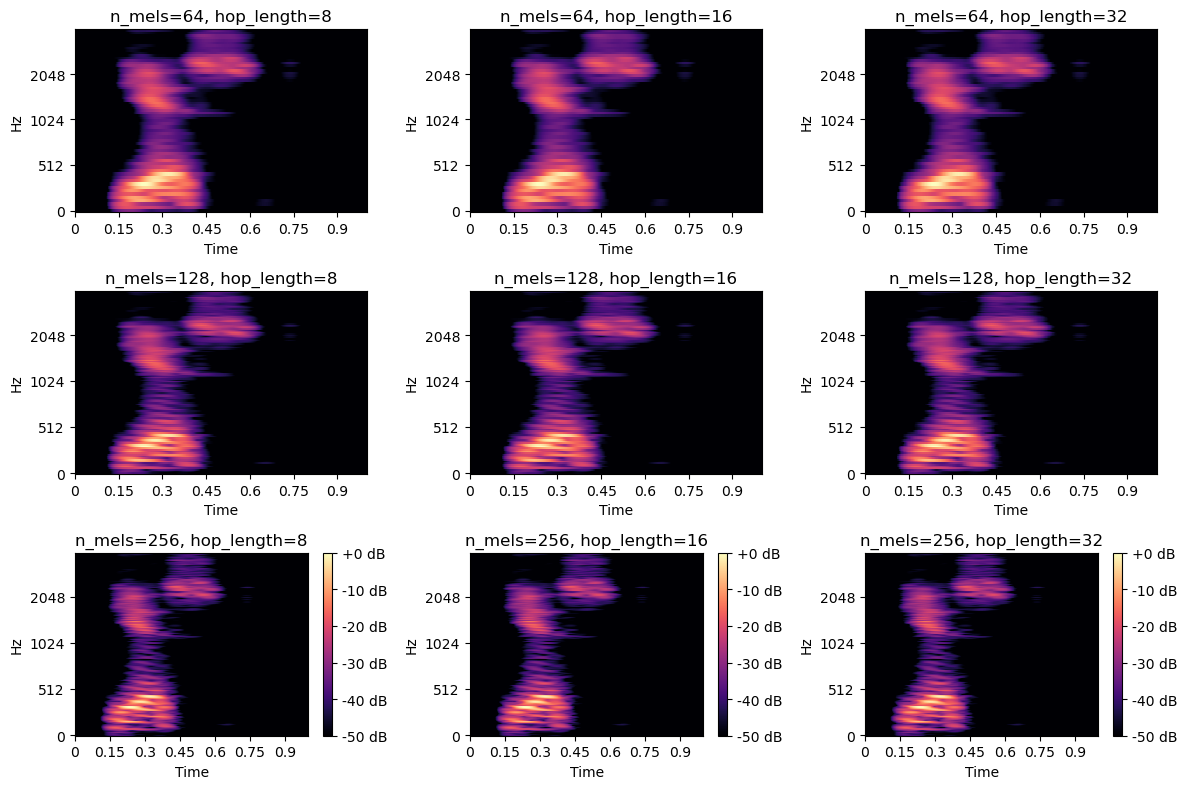

In [36]:

sample_audio = "./SpeechCommands/speech_commands_v0.02/yes/0a2b400e_nohash_2.wav"  

visualize_mel_spectrogram(sample_audio)

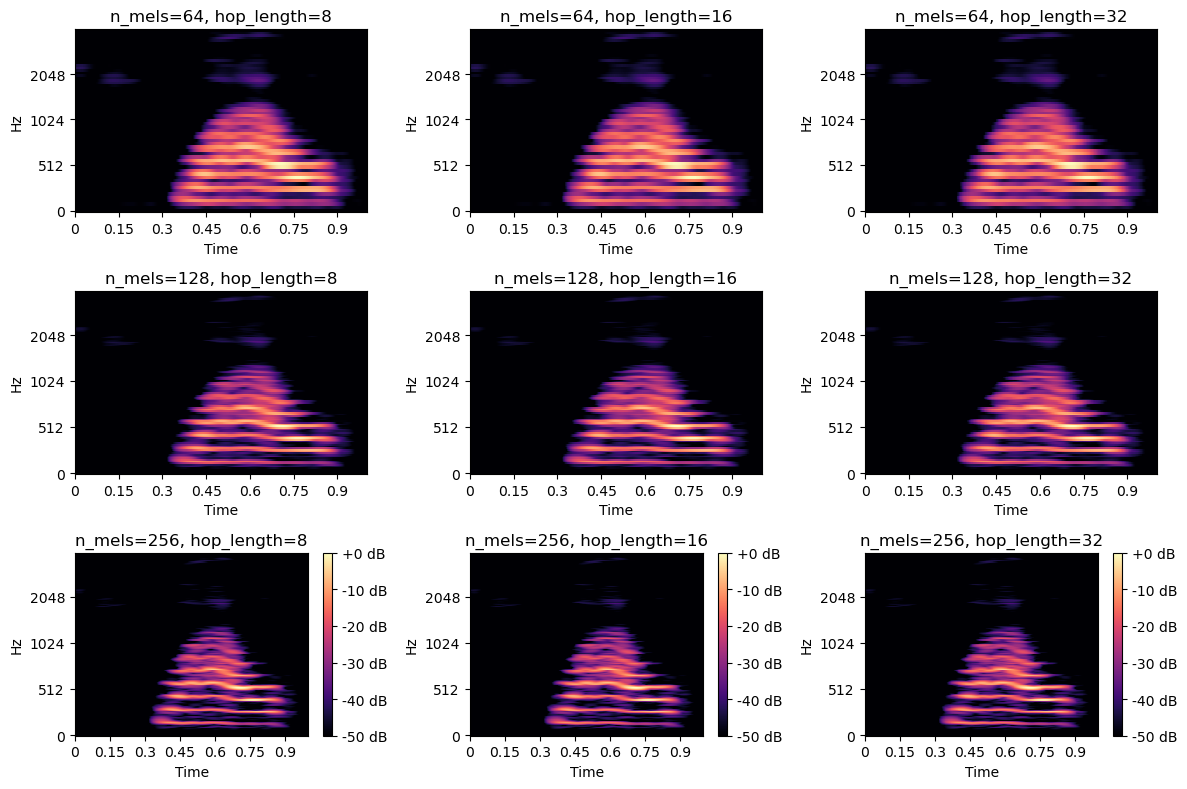

In [40]:
sample_audio2 = "./SpeechCommands/speech_commands_v0.02/wow/0a7c2a8d_nohash_2.wav" 

visualize_mel_spectrogram(sample_audio2)

## Training 

In [60]:
#loading dataset& transfer to mel_spect
import os
import numpy as np
from sklearn.model_selection import train_test_split

def load_data(dataset_path, categories, n_samples=500, sr=16000, n_mels=128, hop_length=32, test_size=0.2):
    """
    loading dataset& transfer to mel_spect
    
    input:
    - dataset_path: path 
    - categories :(yes/wow/no....)
    - n_samples: number of samples
    - sr: default 16kHz
    - n_mels: default  128
    - hop_length: default 32
    - test_size: 2/8

    return:
    - X_train, X_test, Y_train, Y_test: Training & Test datasets (numpy arrays)
    - class_labels: (list)
    """
    X, Y = [], []
    class_labels = categories 

    for label, category in enumerate(categories):
        folder_path = os.path.join(dataset_path, category)
        files = os.listdir(folder_path)[:n_samples]  # get th most n_samples audios

        print(f"loading: {category} ({len(files)} samples)")
        
        for file in files:
            file_path = os.path.join(folder_path, file)
            log_mel_spec = extract_features(file_path)#call 
            #print(f"{file} shape:{log_mel_spec.shape}")
            # append data
            X.append(log_mel_spec)
            Y.append(label)

    # 
    X = np.array(X)
    Y = np.array(Y)

    # normalization Mel-Spectrogram
    X = (X - np.min(X)) / (np.max(X) - np.min(X))

    # divide training & testing
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=42)

    #  CNN input 4 diamension
    X_train = X_train[..., np.newaxis]  #  (samplesize, Frequency Bins,Spectral Bins(time frame),Mel Frequency Bands= 1
    X_test = X_test[..., np.newaxis] 

    print(f"Training_sample: {X_train.shape}, Test_sample: {X_test.shape}")
    return X_train, X_test, Y_train, Y_test, class_labels

# set path&CATEGORIES
DATASET_PATH = "./SpeechCommands/speech_commands_v0.02"
CATEGORIES = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]

# loading
X_train, X_test, Y_train, Y_test, class_labels = load_data(DATASET_PATH, CATEGORIES)


loading: yes (500 samples)
loading: no (500 samples)
loading: up (500 samples)
loading: down (500 samples)
loading: left (500 samples)
loading: right (500 samples)
loading: on (500 samples)
loading: off (500 samples)
loading: stop (500 samples)
loading: go (500 samples)
Training_ample: (4000, 128, 32, 1), Test_sample: (1000, 128, 32, 1)


# CNN model

In [61]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 32, 1)),  # 32  3x3 filter relu:keep positive dismiss neg
    layers.MaxPooling2D((2, 2)),  # maxpooling1

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),#3d to 1d
    layers.Dense(64, activation='relu'),  # dense
    layers.Dense(len(class_labels), activation='softmax')  # output）
])

# compile
model.compile(optimizer='adam',#Adaptive Learning,Faster Convergence
              loss='sparse_categorical_crossentropy',#Integer Labels if one-hot labels:categorical_crossentropy
              metrics=['accuracy'])

# CNN training
model.fit(X_train, Y_train, epochs=10, validation_data=(X_test, Y_test))


2025-02-19 16:26:30.750555: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/oreos/opt/anaconda3/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - accuracy: 0.1326 - loss: 2.2889 - val_accuracy: 0.2660 - val_loss: 2.0422
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - accuracy: 0.3461 - loss: 1.8464 - val_accuracy: 0.4120 - val_loss: 1.6495
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - accuracy: 0.4949 - loss: 1.4265 - val_accuracy: 0.4990 - val_loss: 1.3887
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.5592 - loss: 1.2285 - val_accuracy: 0.4920 - val_loss: 1.3366
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step - accuracy: 0.6358 - loss: 1.0576 - val_accuracy: 0.6120 - val_loss: 1.1292
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step - accuracy: 0.7002 - loss: 0.8954 - val_accuracy: 0.6390 - val_loss: 1.0349
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 19s 78ms/step - accuracy: 0.7459 - loss: 0.7542 - val_accuracy: 0.6440 - val_loss: 1.0358
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step - accuracy: 0.7765 - loss: 0.6597 - 

training Accuracy (0.8452) vs. Validation Accuracy (0.7010)
possible reason:Overfitting 
The model performs well on training data

In [63]:
test_loss, test_acc = model.evaluate(X_test, Y_test)
print(f"✅ Final Test Accuracy: {test_acc:.4f}")
print(f"📉 Final Test Loss: {test_loss:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6794 - loss: 1.0051
✅ Final Test Accuracy: 0.7010
📉 Final Test Loss: 0.9200


In [69]:
##Model 1.0
##add one more conv layer
##add dropout and l2 regularization avoid overfitting

model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 32, 1)),  # 32  3x3 filter relu:keep positive dismiss neg
    layers.MaxPooling2D((2, 2)),  # maxpooling1

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(128, (3, 3), activation='relu'),  # get more complex feature
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),#3d to 1d
    layers.Dense(128, activation='relu',  kernel_regularizer=tf.keras.regularizers.l2(0.001)),  # dense +L2 (0.01/0.001)
    layers.Dropout(0.5),  #  Dropout（for overfitting
    layers.Dense(len(class_labels), activation='softmax')  # output）
])

# compile
model.compile(optimizer='adam',#Adaptive Learning,Faster Convergence
              loss='sparse_categorical_crossentropy',#Integer Labels if one-hot labels:categorical_crossentropy
              metrics=['accuracy'])

# CNN training
model.fit(X_train, Y_train, epochs=20, validation_data=(X_test, Y_test))
# 15 round
#accuracy: 0.6729 - loss: 1.0237 - val_accuracy: 0.7580 - val_loss: 0.9138

Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 86ms/step - accuracy: 0.1317 - loss: 2.4026 - val_accuracy: 0.2870 - val_loss: 2.0442
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - accuracy: 0.2857 - loss: 1.9978 - val_accuracy: 0.4270 - val_loss: 1.6748
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step - accuracy: 0.3749 - loss: 1.7230 - val_accuracy: 0.5430 - val_loss: 1.4462
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - accuracy: 0.4539 - loss: 1.5426 - val_accuracy: 0.6110 - val_loss: 1.2364
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 91ms/step - accuracy: 0.5011 - loss: 1.4058 - val_accuracy: 0.6500 - val_loss: 1.1066
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 91ms/step - accuracy: 0.5577 - loss: 1.2808 - val_accuracy: 0.6740 - val_loss: 1.0218
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step - accuracy: 0.6128 - loss: 1.1294 - val_accuracy: 0.7080 - val_loss: 0.9520
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - accuracy: 0.6409 - loss: 1.0377 - 

# Use Wav2Vec2.0 

In [ ]:
pip install torch transformers librosa datasets

The Wave2Vec 2.0 model developed by Facebook AI Research (FAIR) is a self-supervised speech representation learning framework based on deep learning, which has made a major breakthrough in the field of automatic speech recognition (ASR). Wave2Vec 2.0 learns meaningful speech representations directly from **raw audio** waveforms by training models without requiring large amounts of manually transcribed data.

In [71]:
import torch
import librosa
from transformers import Wav2Vec2Processor, Wav2Vec2Model

#  Wav2Vec2.0  pre-trained model
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h") #960hours english base model
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")

# loading audio
audio_path = "./SpeechCommands/speech_commands_v0.02/yes/0a2b400e_nohash_2.wav"
y, sr = librosa.load(audio_path, sr=16000)  # 16kHz 

# pre-process audio
input_values = processor(y, return_tensors="pt", sampling_rate=16000).input_values

# get features
with torch.no_grad():
    outputs = model(input_values)

# feature vector
wav2vec_features = outputs.last_hidden_state  # (batch_size, time_steps, feature_dim)
print(f"Wav2Vec2.0 feature shape: {wav2vec_features.shape}")


Downloading:   0%|          | 0.00/159 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/163 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.56k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/291 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/360M [00:00<?, ?B/s]

/Users/oreos/opt/anaconda3/lib/python3.9/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2Model: ['lm_head.weight', 'lm_head.bias']
- This IS expected if you are initializing Wav2Vec2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2Model were not initialized from the model checkp

Wav2Vec2.0 feature shape: torch.Size([1, 49, 768])


In [74]:
import os
from sklearn.model_selection import train_test_split

DATASET_PATH = "./SpeechCommands/speech_commands_v0.02/"

all_audio_paths = []
all_labels = []

CATEGORIES = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]  

for label in CATEGORIES:
    label_path = os.path.join(DATASET_PATH, label)
    if os.path.isdir(label_path):  
        for file_name in os.listdir(label_path):
            if file_name.endswith(".wav"):  # only deal .wav 
                all_audio_paths.append(os.path.join(label_path, file_name))
                all_labels.append(CATEGORIES.index(label))  

X_train_paths, X_test_paths, Y_train, Y_test = train_test_split(all_audio_paths, all_labels, test_size=0.2, random_state=12)

print(f"Trainset: {len(X_train_paths)}")
print(f"Testset: {len(X_test_paths)}")


Trainset: 30836
Testset: 7710


In [1]:
# too slow using CPU, go to google colab and use gpu